# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Subsampling images of fashion mnist

As we need to create a look up table we need to reduce the input neuron size. Thus, we will need to sample our images

In [6]:
#creating the sample indexes
skipsinIndexes = 2
if 28%skipsinIndexes==0:
    newShape = 28//skipsinIndexes
else:
    newShape = 28//skipsinIndexes + 1
Y, X = np.meshgrid([i for i in range(0, 28, skipsinIndexes)], [i for i in range(0, 28, skipsinIndexes)])
X, Y

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
        [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
        [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
        [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]]),
 array([[ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26],
        

In [7]:
sampled_x_train = np.zeros(((newShape)**2, x_train.shape[1]))
sampled_x_val = np.zeros(((newShape)**2, x_val.shape[1]))
for i in range(x_train.shape[1]):
    samp = x_train[:, i].reshape((28, -1))
    sampled_x_train[:, i] = samp[X, Y].flatten()
for i in range(x_val.shape[1]):
    samp = x_val[:, i].reshape((28, -1))
    sampled_x_val[:, i] = samp[X, Y].flatten()

Text(0.5, 1.0, 'Subsampled version of the image with samples every 2 indices')

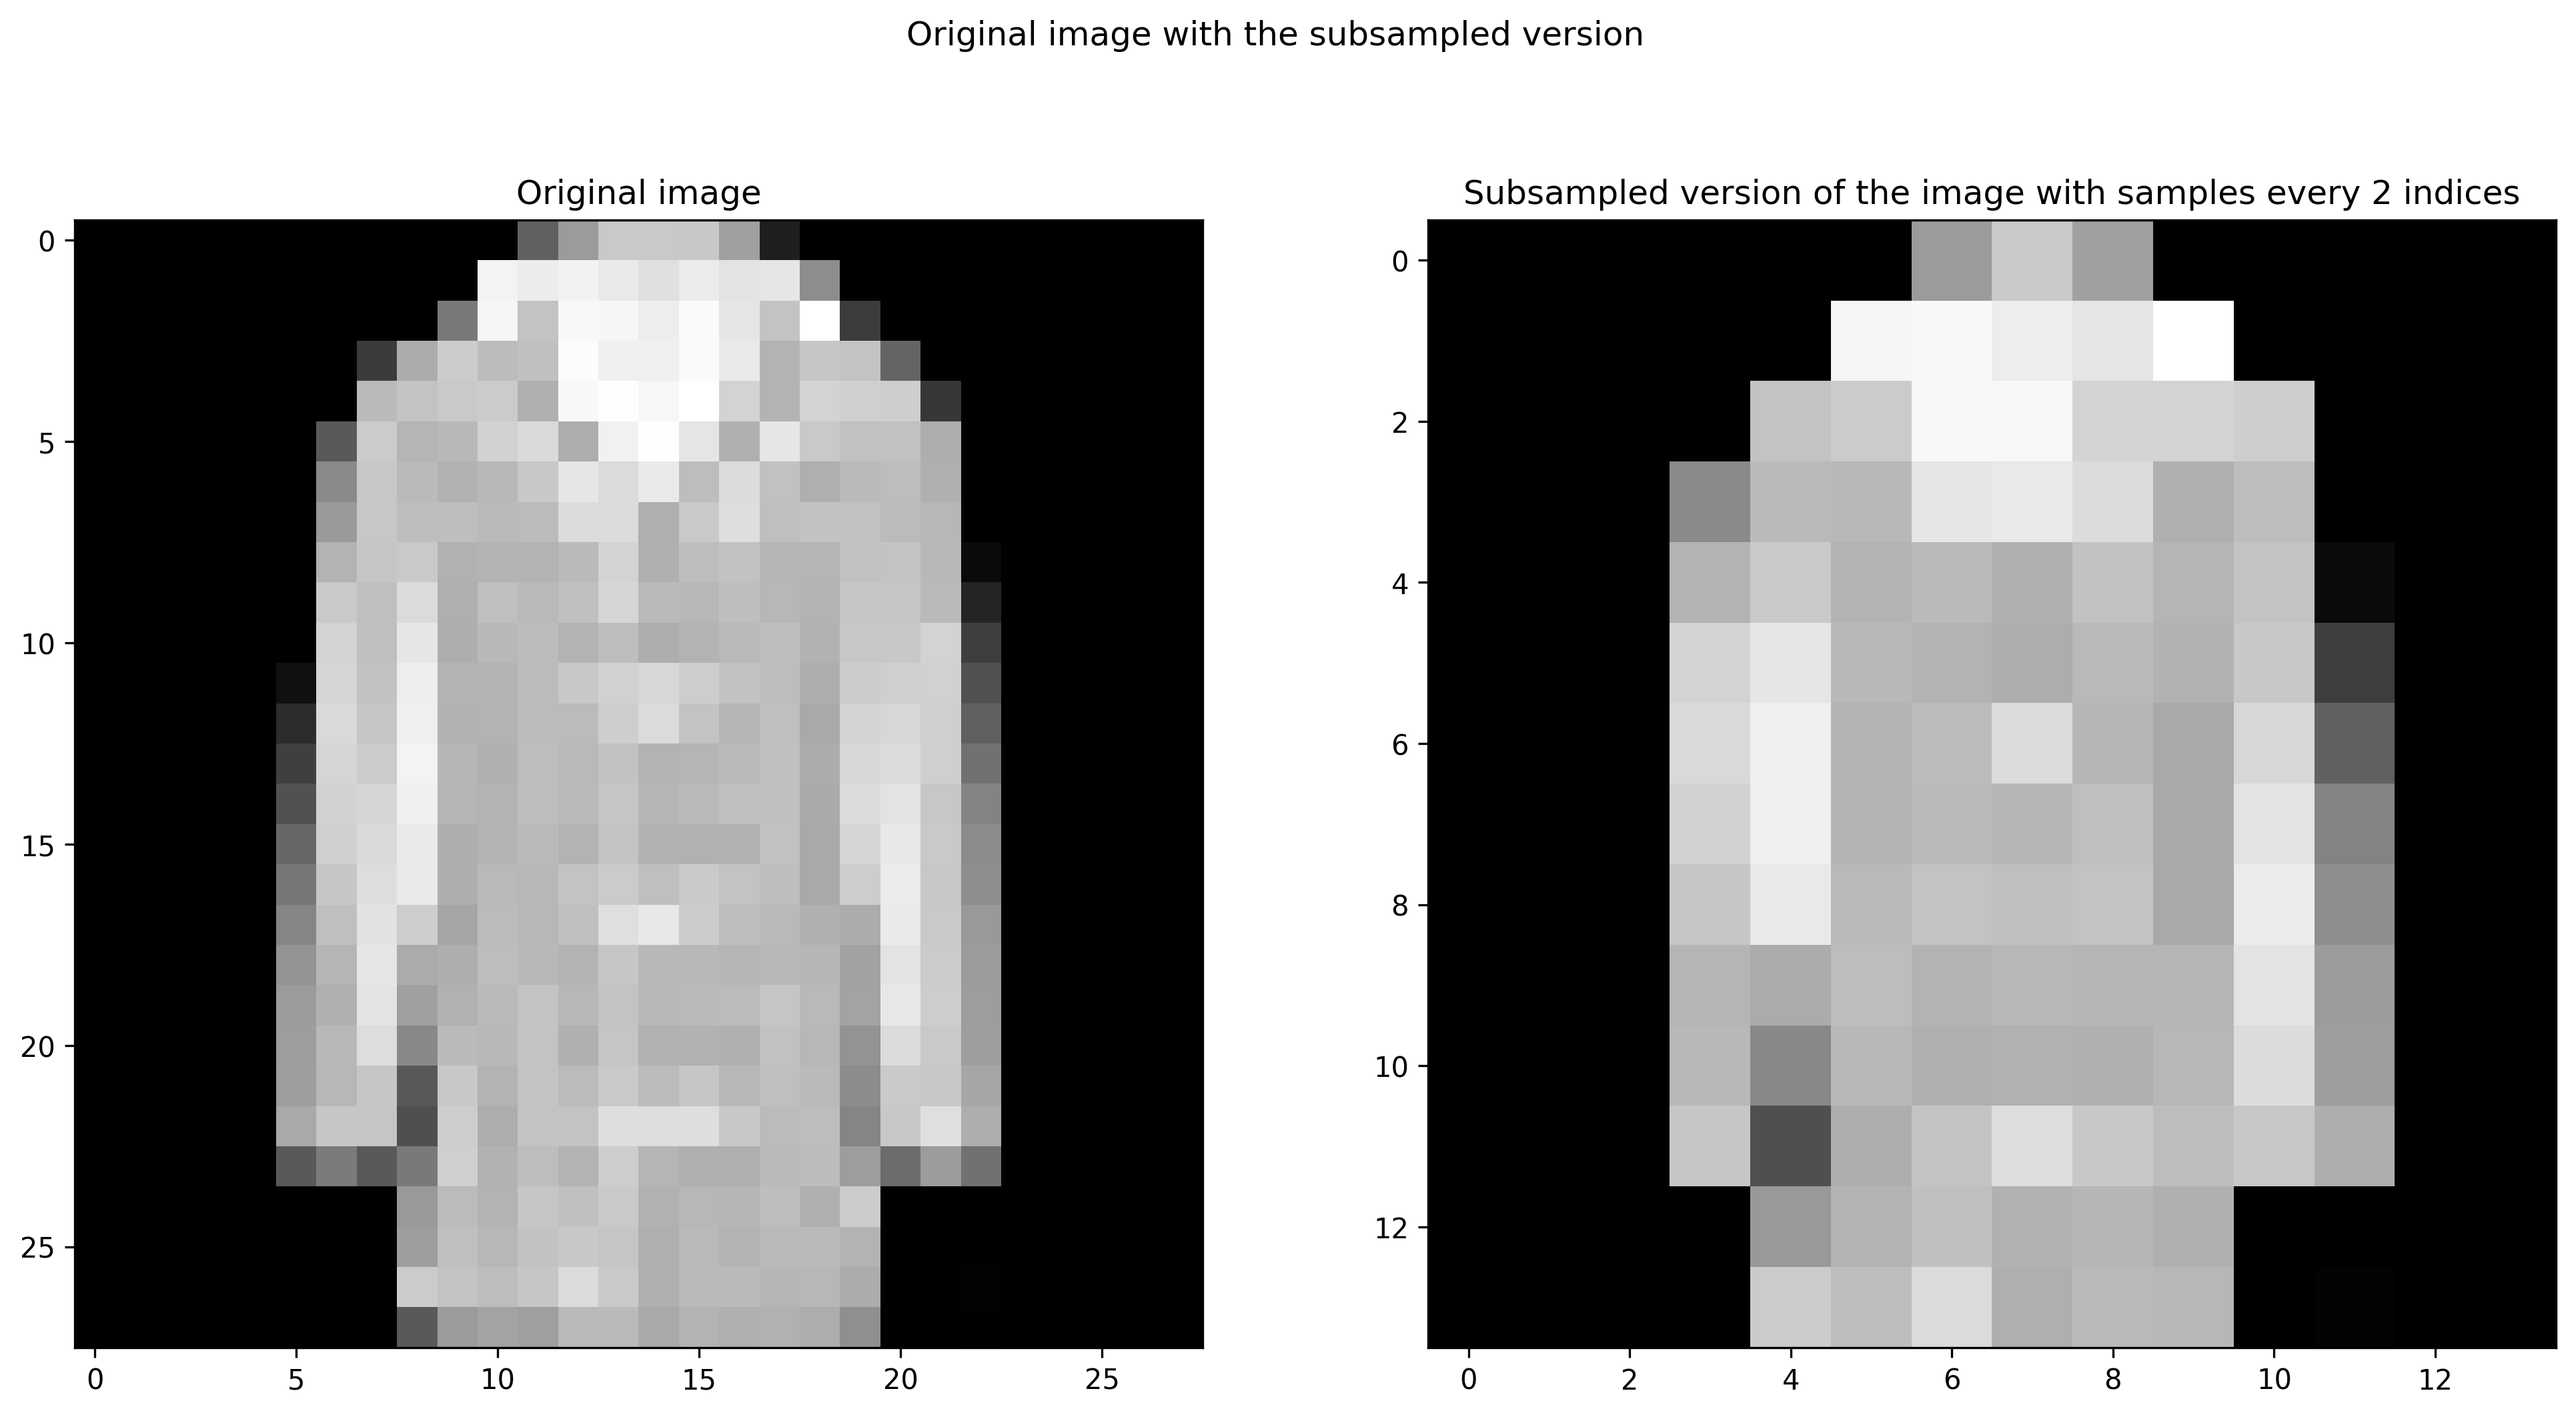

In [8]:
plt.figure(figsize = (16, 8))
plt.gcf().set_dpi(300)
ind = np.random.randint(0, x_train.shape[1])
plt.suptitle("Original image with the subsampled version")
plt.subplot(121)
plt.imshow(x_train[:, ind].reshape(28, -1), cmap = 'gray', vmin =0, vmax = 1)
plt.title("Original image")
plt.subplot(122)
plt.imshow(sampled_x_train[:, ind].reshape(newShape, -1), cmap = 'gray', vmin =0, vmax = 1)
plt.title(f"Subsampled version of the image with samples every {skipsinIndexes} indices")

# Training software BP with new subsampled version of MNIST

In [9]:
def params_init(newShape, midLayerSize, seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(midLayerSize,newShape) - 0.5
  b1 = np.random.rand(midLayerSize,1) - 0.5
  W2 = np.random.rand(10,midLayerSize) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [10]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [11]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10e-16)), axis = 0)
  return loss

In [12]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

In [13]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

In [14]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [15]:
def batch_grad_descent(X,Y,iter, lr, midLayerSize, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}
  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = None)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(sampled_x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score} Val loss: {np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      # plt.figure()
      # plt.hist(W1.flatten())

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [16]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(sampled_x_train,y_train,iter=100, lr=0.1,midLayerSize = 10, print_op=20);

Params Initialised
Iteration: 20
Train accuracy: 79.77142857142857
Val accuracy: 79.3 Val loss: 3856.8510344316223
Iteration: 40
Train accuracy: 81.41111111111111
Val accuracy: 81.2 Val loss: 3563.173754866464
Iteration: 60
Train accuracy: 82.31428571428572
Val accuracy: 81.48571428571428 Val loss: 3443.457484271677
Iteration: 80
Train accuracy: 82.73174603174603
Val accuracy: 81.67142857142858 Val loss: 3379.089516267077
Iteration: 100
Train accuracy: 83.06825396825397
Val accuracy: 81.94285714285714 Val loss: 3330.5946866380436


### Generic functions related to variability

In [17]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [18]:
def initMosParam(shape, mu, sigma, vDD, precision, k=100):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    #Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    return (iOn, iOnNominal, iOff)

In [19]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [20]:
def createLookUpTable2d(weightArray, currents, precision, step, discreteSteps, wRange):
    dis = [(-1)*i for i in discreteSteps[::-1]] + discreteSteps
    finalLookUp = np.zeros((weightArray.shape[0], weightArray.shape[1], len(dis)))
    k = 0
    for i in dis:
        maskee = np.ones_like(weightArray, dtype = float)*i
        maskeeTransformed  = weightTransformWithVariability(maskee, currents, precision, step, discreteSteps, wRange)
        finalLookUp[:, :, k] += maskeeTransformed
        k +=1
    return finalLookUp 

In [21]:
def nearest(lookUpDiff, weightUpdate):
    # W1new = W1  - (lr*dW1)
    # we want to compare and find W1new such that |W1new-(W1  - (lr*dW1))| has least error!!!
    # We look at L1 error and take the minimum of this!
    idx = np.argmin(np.abs(lookUpDiff - weightUpdate[:,:,None]), axis = 2)
    return idx

In [22]:
def findNextWeight(lookUp, lookUpDiff, weightUpdate):
    idx = np.indices(nearest(lookUpDiff, weightUpdate).shape)
    #discrete lookup needs to be used
    return lookUp[idx[0],idx[1],nearest(lookUpDiff, weightUpdate)]

In [23]:
def findNextState(disArr, lookUpDiff, weightUpdate):
    return disArr[nearest(lookUpDiff, weightUpdate)]

## Verifying correctness of look up table code

In [146]:
mu = 0.7
sigma = 0.001
onoff = 10000
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 10
midLayerSize = 10
lr = 0.1

In [137]:
W1 = np.arange(-1, 1, 0.02).reshape((10,10))

In [138]:
disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
W1Currents = initMosParam((midLayerSize, 10), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff



W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)

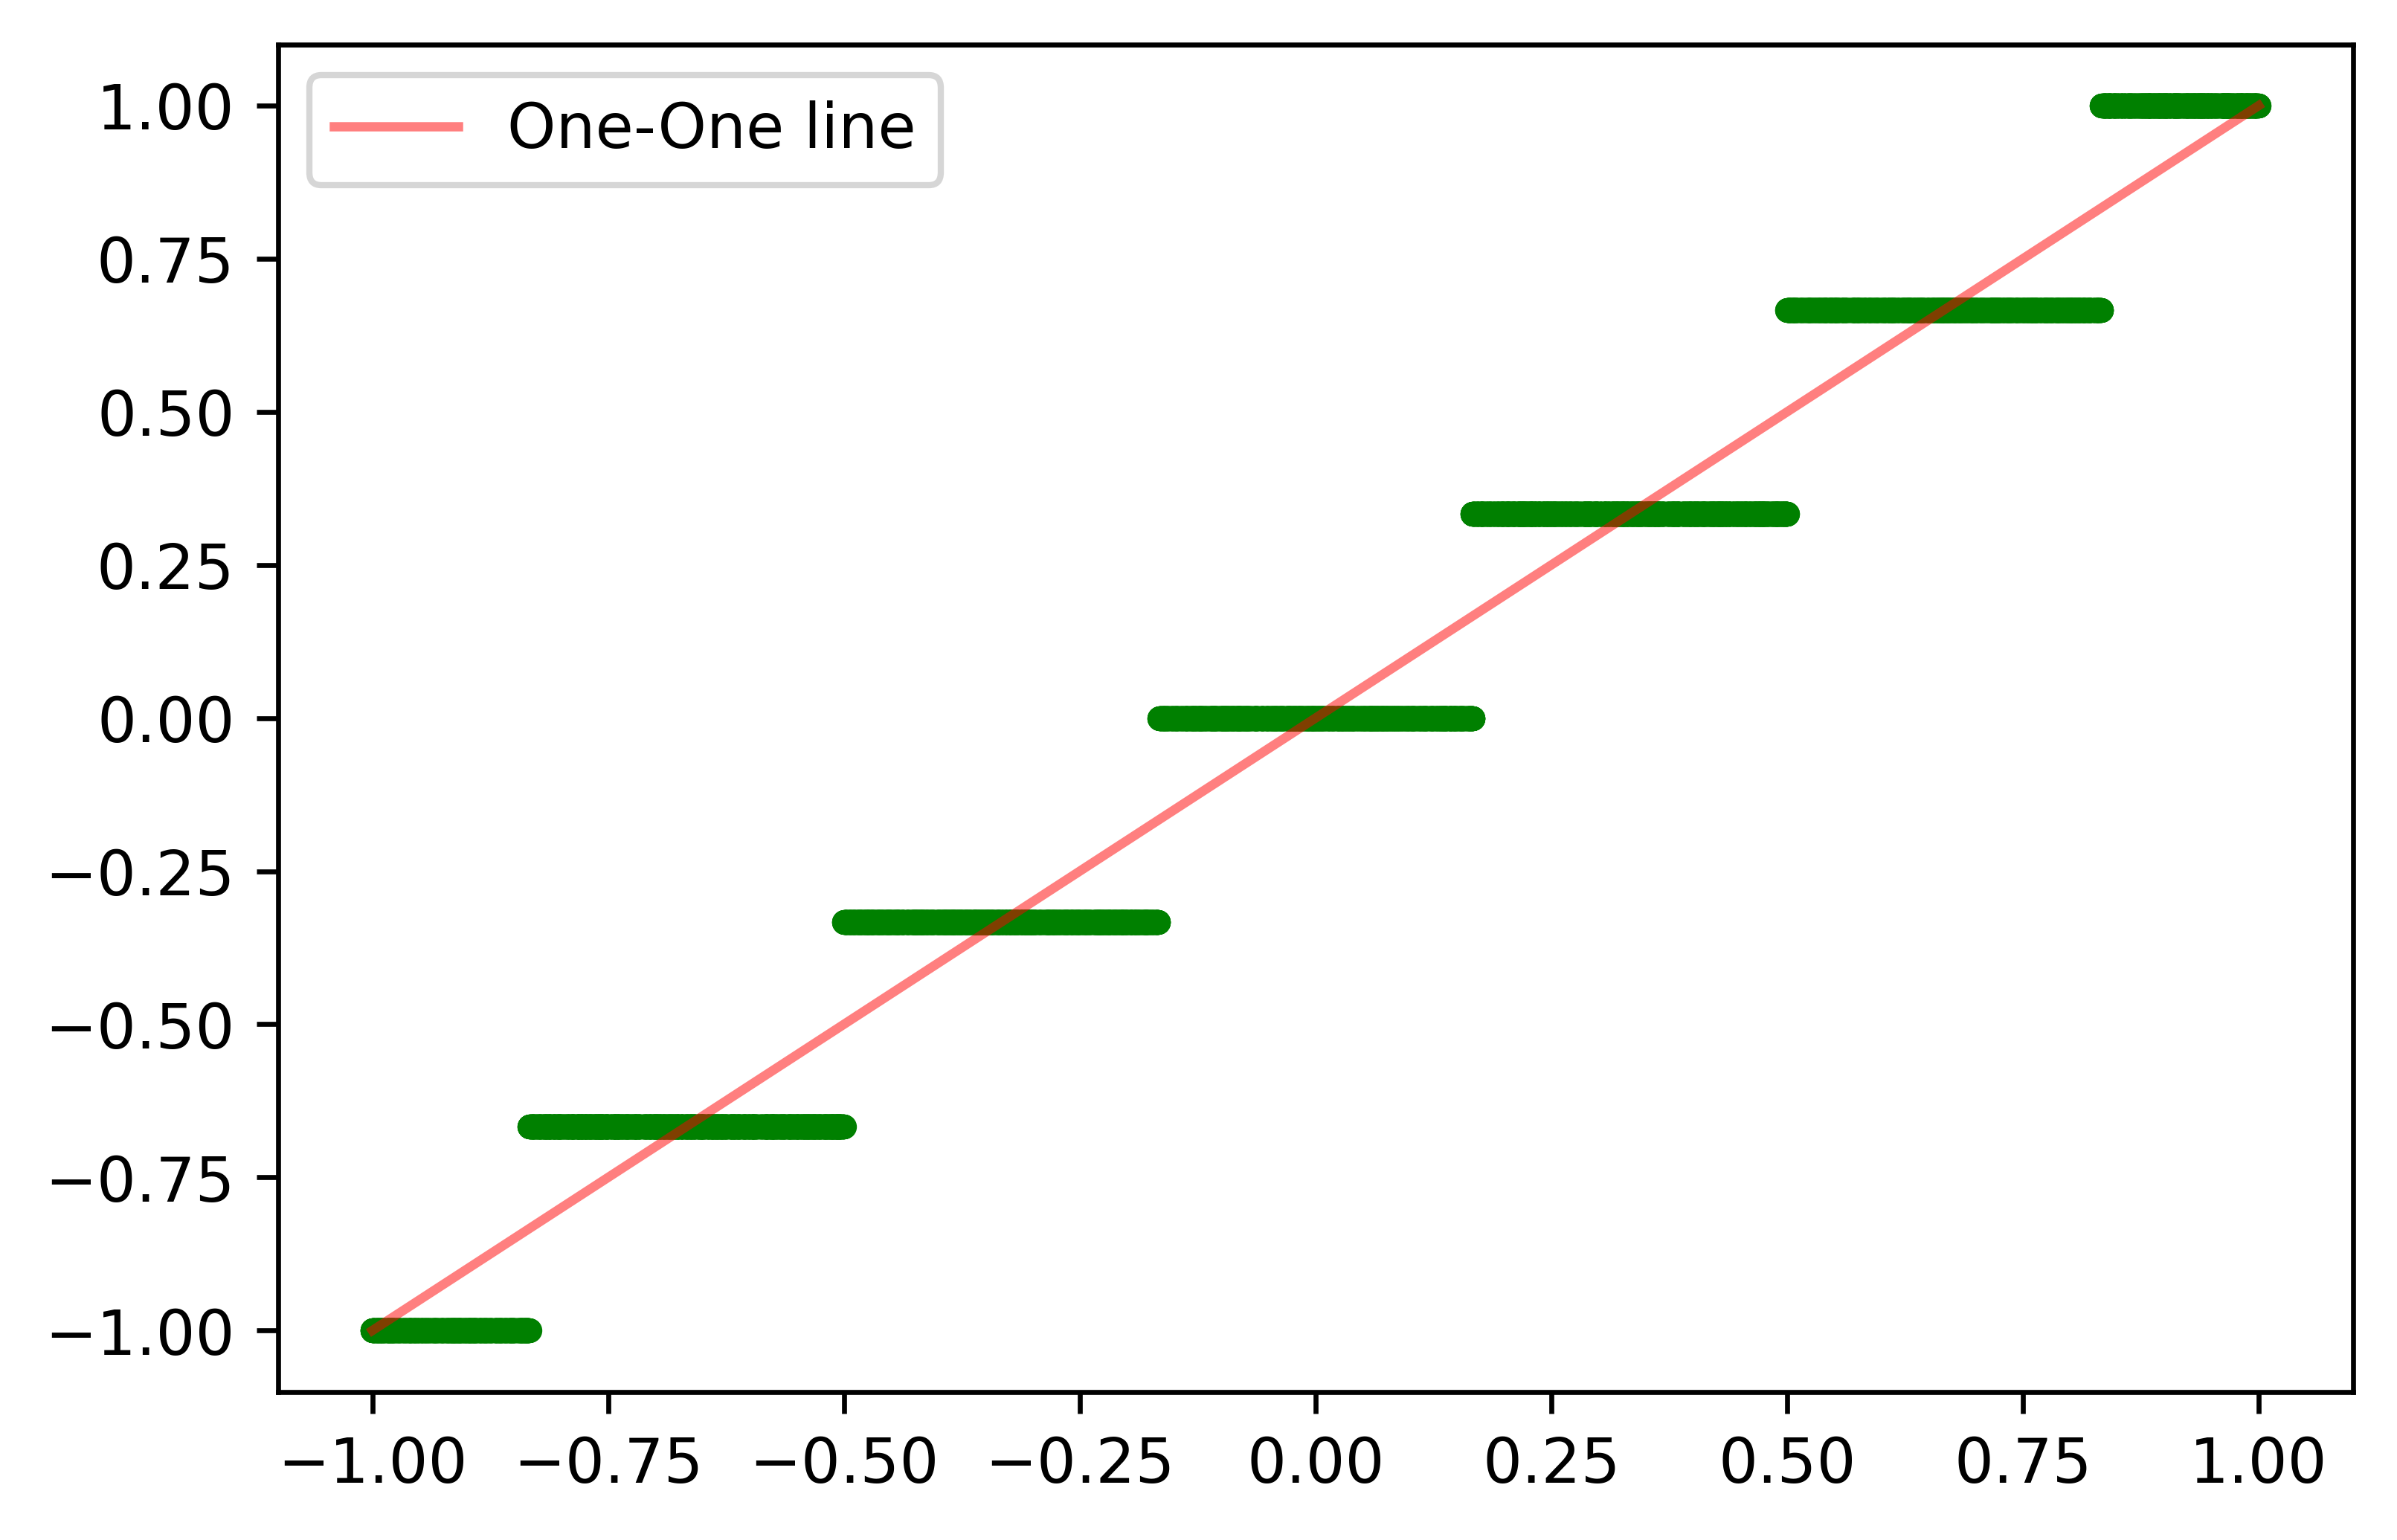

In [147]:
plt.rcParams['figure.dpi'] = 600
plt.figure()
for i in range(0, 10):
     for j in range(0, 10):
        plt.plot(disArr, W1lookUp[i, j, :], 'b.', alpha = 0.4)
for _ in range(20):
        W1rand = np.random.rand(10, 10)*2 - 1
        plt.plot(W1rand.flatten(), weightTransformWithVariability(W1rand, W1Currents, precision, step, discreteSteps, wRange).flatten(), 'g.')
plt.plot(disArr, disArr, 'r', alpha = 0.5, label = "One-One line")
plt.legend()

The blue dots demarcate the varibility transforms of the qauntized values for each SRAM cell, while the green dots signify randomly sampled weight arrays whose variability transforms are plotted.

We notice that the green dots just sample the blue dots. This is correct since random sampled values are first quantized i.e to a value lying in the quantized space and then variability transform is applied. This would be equivalent to sampling a value from the variability transforms of the quantized value of that particular SRAM cell.

Further, we also notice the "gaussianess" of our distributions. Green dots lie most dense along the 'one-one' line showing higher probability about mean and then start flattening out to zero aroung mean. This spread depends on the sigma we would choose

## Checking the 'nearest' code is working with a toy example

Say in actual bit space the srams can only take values 1 to 10 (true states)

Due to some reason(srams nature etc) they get mapped to some integer between -100 to 100. This represents variability. At the end of the day variability is just a map that takes a bit stream to an analogous value which we try to mimic in oue toy example.

We again come up with 'fake' current states of the Sram. Notice that current state must have the mapping as described above for the lookup table generation since this is the value we infer and hence must be sampled at random(for the experiment) from the look up table generated as explained above.

Now, the weight updates can we random integers that are generated by some formula which takes a loss function, current state and some date as input.

In [33]:
statesQaunt = np.arange(10)+1
statesQaunt

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [34]:
#create a toy look up table
# this means that each sram indexed by (i,j) from the cell array can take values in the array given by (i,j,:)
lookUp = np.random.randint(-12, 12, (4, 5, 10))
lookUp

array([[[  2,  -6,   1,  -2, -12,   1,  -5,  -5,  -5,  -9],
        [ -7,   5,   1,   4,   3, -10,  -7,   4,  -9,   0],
        [  5,   2,  -7,  -4,   1,  -7,   9,   8,  -4,  -9],
        [ -5,   2,  -4,  -8, -11, -11,   0,   1,   9,  -4],
        [ -1,   8,  -1, -10,  -4,   3,   6,  -1, -12,  -4]],

       [[  7,  -1,  11,   9,   3,  11,  -4,  -8,  -8,   2],
        [  7,   7,   1,   5,   9,   1,   8,  -1,  -5,   5],
        [ -8,   0,  -9,   0,  -2,  -3,  -5,  -7,   4,  -3],
        [  5,   7, -12,  10,  -8,   5,  -1,  -8,   6,   0],
        [ -6,  -8,  -6,   2,   7,  11,  -8,  -8,  -6, -10]],

       [[ -1,   5,  -1,  -9,   1,   0,   3,  -9,  -3,  -1],
        [ -8,  -3,   7,  -5,  -7,  10,   6,  10,  -7,   6],
        [  0,  -7,   5,   4,   5,   7,   1, -10,   1,   0],
        [  8,  -5,   4, -12,   5,   3,  -9,   9,  -9,  -6],
        [  2,   8,  -8,   4, -11,  10,  -7,   8,   6,  -6]],

       [[-11,   4,   5,  -2,  11,  -3,   2, -10, -10,  -8],
        [-12,  10,   5,  -4,   3, 

In [35]:
currStateVar = np.zeros((4,5), dtype = int)
currState = np.zeros((4,5), dtype = int)
for i in range(4):
    for j in range(5):
        k = np.random.randint(0, 10)
        currState[i,j] = k
        currStateVar[i, j] = lookUp[i,j,k]
currState+1, currStateVar #+1  is done cause states start from 1 and not 0

(array([[ 2,  1,  7,  2,  7],
        [10, 10,  5,  2,  1],
        [ 9,  2,  1,  2,  9],
        [ 1,  4,  6,  8,  2]]),
 array([[ -6,  -7,   9,   2,   6],
        [  2,   5,  -2,   7,  -6],
        [ -3,  -3,   0,  -5,   6],
        [-11,  -4,  -3,  -8,   8]]))

In [36]:
weightUpd = np.random.randint(-5, 5, (4, 5))
weightUpd

array([[ 3, -2, -5,  2, -1],
       [-1,  0,  0, -1,  3],
       [-2, -5,  4, -1,  2],
       [-1,  2,  1,  3, -1]])

In [37]:
idx = nearest(lookUp, currStateVar + weightUpd) #finds the closest match of the addition currState+weightpd with the look up table generate
idx

array([[3, 8, 0, 1, 6],
       [9, 3, 4, 8, 0],
       [8, 0, 3, 9, 1],
       [0, 8, 5, 0, 0]], dtype=int64)

In [38]:
lookUp, currStateVar + weightUpd, np.abs(lookUp - (currStateVar + weightUpd)[:,:,None])

(array([[[  2,  -6,   1,  -2, -12,   1,  -5,  -5,  -5,  -9],
         [ -7,   5,   1,   4,   3, -10,  -7,   4,  -9,   0],
         [  5,   2,  -7,  -4,   1,  -7,   9,   8,  -4,  -9],
         [ -5,   2,  -4,  -8, -11, -11,   0,   1,   9,  -4],
         [ -1,   8,  -1, -10,  -4,   3,   6,  -1, -12,  -4]],
 
        [[  7,  -1,  11,   9,   3,  11,  -4,  -8,  -8,   2],
         [  7,   7,   1,   5,   9,   1,   8,  -1,  -5,   5],
         [ -8,   0,  -9,   0,  -2,  -3,  -5,  -7,   4,  -3],
         [  5,   7, -12,  10,  -8,   5,  -1,  -8,   6,   0],
         [ -6,  -8,  -6,   2,   7,  11,  -8,  -8,  -6, -10]],
 
        [[ -1,   5,  -1,  -9,   1,   0,   3,  -9,  -3,  -1],
         [ -8,  -3,   7,  -5,  -7,  10,   6,  10,  -7,   6],
         [  0,  -7,   5,   4,   5,   7,   1, -10,   1,   0],
         [  8,  -5,   4, -12,   5,   3,  -9,   9,  -9,  -6],
         [  2,   8,  -8,   4, -11,  10,  -7,   8,   6,  -6]],
 
        [[-11,   4,   5,  -2,  11,  -3,   2, -10, -10,  -8],
         [-12, 

Look at the above example:

Track the state of any SRAM cell and you will see that the code is giving the correct variability aware addition. In some sense it is giving us much more - this is true for no matter what distribution of varaibility we choose

Also see where we go wrong with variability blind updates.

Add the two 'blindly', since we have states from 1 to 10 loop around any integer not in this range i.e {$r \, mod (10) + 1$} and see where this goes wrong by looking at the actual value it would emit at that state versus the value we want it to emit at that stage

In [39]:
findNextState(statesQaunt, lookUp, currStateVar + weightUpd), currState+1

(array([[ 4,  9,  1,  2,  7],
        [10,  4,  5,  9,  1],
        [ 9,  1,  4, 10,  2],
        [ 1,  9,  6,  1,  1]]),
 array([[ 2,  1,  7,  2,  7],
        [10, 10,  5,  2,  1],
        [ 9,  2,  1,  2,  9],
        [ 1,  4,  6,  8,  2]]))

Code seems to work well

# Training

In [150]:
def batch_grad_descentBPVarUpdateComp(X,Y,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1bu = W1.copy()
  b1bu = b1.copy()
  W2bu = W2.copy()
  b2bu = b2.copy()

  #variability aware updates
  W1va = W1.copy()
  b1va = b1.copy()
  W2va = W2.copy()
  b2va = b2.copy()

  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)



  W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)
  b1lookUp = createLookUpTable2d(b1, b1Currents, precision, step, discreteSteps, wRange)
  W2lookUp = createLookUpTable2d(W2, W2Currents, precision, step, discreteSteps, wRange)
  b2lookUp = createLookUpTable2d(b2, b2Currents, precision, step, discreteSteps, wRange)


  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
      W1varoc = weightTransformWithVariability(W1va, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1va, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2va, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2va, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)


      #W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)
      #actualW1vaUpdate = W1varoc - weightTransformWithVariability(findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1), W1Currents, precision, step, discreteSteps, wRange)
      W1va = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      b1va = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      W2va = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      b2va = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))
      


      #blind updates
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1bu, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)

      W1bu, b1bu, W2bu, b2bu = param_update(W1varoc, b1varoc, W2varoc,b2varoc, dW1bu, db1, dW2, db2, lr = lr)

      W1bu = roundArbitrary(W1bu, step, wRange)#weights have to maintained as their digitized versions
      b1bu = roundArbitrary(b1bu, step, wRange)
      W2bu = roundArbitrary(W2bu, step, wRange)
      b2bu = roundArbitrary(b2bu, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(sampled_x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


      W1varoc = weightTransformWithVariability(W1va, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1va, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2va, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2va, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(sampled_x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      vaAccTrainAcc = accuracy(predictions(A2_train), Y)
      vaTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      vaAccValAcc = accuracy(predictions(A2_val), y_val)
      vaValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))
  
      train_acc.append([buAccTrainAcc, vaAccTrainAcc])
      print(f'Training :: Blind : {buAccTrainAcc} :: VA : {vaAccTrainAcc}')


      val_acc.append([buAccValAcc, vaAccTrainAcc])
      print(f'Validation  :: Blind : {buAccValAcc} :: VA : {vaAccValAcc} :: Blind Loss : {buValLoss} :: Val Loss : {vaValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


## Running for different variability cases


In [35]:
mu = 0.7
sigma = 0
onoff = 1000000000000000000000000000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10
lr = 0.1

In [36]:
#finding qauantization accuacy
batch_grad_descentBPVarUpdateComp(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1)

Params Initialised
Iteration: 1
Training :: Blind : 59.99523809523809 :: VA : 59.99523809523809
Validation  :: Blind : 59.5 :: VA : 59.5 :: Blind Loss : 7951.370549390735 :: Val Loss : 7951.370549390735
Iteration: 2
Training :: Blind : 65.28412698412698 :: VA : 65.29206349206349
Validation  :: Blind : 65.22857142857143 :: VA : 65.2 :: Blind Loss : 6417.472873123073 :: Val Loss : 6417.496553181251
Iteration: 3
Training :: Blind : 67.84126984126985 :: VA : 67.84126984126985
Validation  :: Blind : 67.94285714285714 :: VA : 67.95714285714286 :: Blind Loss : 5868.195060883419 :: Val Loss : 5868.20821798106
Iteration: 4
Training :: Blind : 69.7968253968254 :: VA : 69.7936507936508
Validation  :: Blind : 69.69999999999999 :: VA : 69.68571428571428 :: Blind Loss : 5538.975509536216 :: Val Loss : 5538.8254789132725
Iteration: 5
Training :: Blind : 71.52222222222223 :: VA : 71.51111111111112
Validation  :: Blind : 71.38571428571429 :: VA : 71.35714285714285 :: Blind Loss : 5303.996641420117 :: V

(array([[ 0.20537241,  0.08229548,  0.37118437, ...,  0.09426129,
         -0.23687424, -0.18266178],
        [-0.26300366, -0.30891331, -0.33040293, ...,  0.44126984,
          0.03540904,  0.0017094 ],
        [ 0.25128205,  0.09206349,  0.10915751, ...,  0.19365079,
          0.08009768,  0.45079365],
        ...,
        [-0.32722833, -0.17289377, -0.08400488, ..., -0.12332112,
          0.41953602,  0.204884  ],
        [ 0.23858364, -0.25518926, -0.16019536, ...,  0.17313797,
          0.48131868, -0.29157509],
        [-0.38730159, -0.30891331,  0.15677656, ..., -0.14188034,
         -0.16312576, -0.19365079]]),
 array([[-0.38168498],
        [-0.12478632],
        [-0.42393162],
        [ 0.22002442],
        [-0.003663  ],
        [-0.04615385],
        [-0.10940171],
        [-0.25885226],
        [-0.16385836],
        [ 0.15457875]]),
 array([[-0.49035409, -0.08693529,  0.44151404, -0.04273504,  0.03125763,
         -0.05518926,  0.01465201, -0.04224664,  0.08131868, -0.409

In [61]:
finTrainAcc = []
finValAcc = []
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
for sigma in Sigma:
    _, _, _, _, train_acc, val_acc, _, _, _ = batch_grad_descentBPVarUpdateComp(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1)
    finTrainAcc.append(train_acc[-1])
    finValAcc.append(val_acc[-1])

Params Initialised
Iteration: 1
Training :: Blind : 13.884126984126985 :: VA : 21.08888888888889
Validation  :: Blind : 13.614285714285716 :: VA : 20.9 :: Blind Loss : 39796.61744186137 :: Val Loss : 15345.860593464768
Iteration: 2
Training :: Blind : 14.355555555555554 :: VA : 21.880952380952383
Validation  :: Blind : 14.52857142857143 :: VA : 21.52857142857143 :: Blind Loss : 37298.55259902296 :: Val Loss : 15243.385978275928
Iteration: 3
Training :: Blind : 13.403174603174604 :: VA : 20.615873015873014
Validation  :: Blind : 13.32857142857143 :: VA : 20.67142857142857 :: Blind Loss : 40714.80578663027 :: Val Loss : 15238.323136194253
Iteration: 4
Training :: Blind : 12.730158730158731 :: VA : 21.322222222222223
Validation  :: Blind : 12.485714285714286 :: VA : 21.257142857142856 :: Blind Loss : 39042.18904450647 :: Val Loss : 15202.201175002308
Iteration: 5
Training :: Blind : 15.923809523809524 :: VA : 20.846031746031745
Validation  :: Blind : 16.114285714285714 :: VA : 20.84285714

In [66]:
Sigma = 10**(-np.arange(2, 3, 0.1)[1:])
for sigma in Sigma:
    _, _, _, _, train_acc, val_acc, _, _, _ = batch_grad_descentBPVarUpdateComp(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1)
    finTrainAcc.append(train_acc[-1])
    finValAcc.append(val_acc[-1])

Params Initialised
Iteration: 1
Training :: Blind : 18.887301587301586 :: VA : 51.087301587301596
Validation  :: Blind : 18.82857142857143 :: VA : 50.02857142857143 :: Blind Loss : 16498.73137950569 :: Val Loss : 9652.901441483873
Iteration: 2
Training :: Blind : 22.890476190476193 :: VA : 54.24920634920635
Validation  :: Blind : 22.614285714285714 :: VA : 53.142857142857146 :: Blind Loss : 16856.073953386855 :: Val Loss : 8922.393926461627
Iteration: 3
Training :: Blind : 21.43015873015873 :: VA : 56.01587301587302
Validation  :: Blind : 21.228571428571428 :: VA : 54.92857142857142 :: Blind Loss : 16967.1930039105 :: Val Loss : 8606.2781067619
Iteration: 4
Training :: Blind : 20.736507936507937 :: VA : 56.53174603174603
Validation  :: Blind : 20.457142857142856 :: VA : 55.51428571428572 :: Blind Loss : 17160.60171185719 :: Val Loss : 8427.348186977819
Iteration: 5
Training :: Blind : 21.950793650793653 :: VA : 56.82539682539682
Validation  :: Blind : 21.242857142857144 :: VA : 55.7285

In [96]:
Sigma = 10**(-np.arange(3, 4, 0.1))
for sigma in Sigma:
    _, _, _, _, train_acc, val_acc, _, _, _ = batch_grad_descentBPVarUpdateComp(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1)
    finTrainAcc.append(train_acc[-1])
    finValAcc.append(val_acc[-1])

Params Initialised
Iteration: 1
Training :: Blind : 46.59206349206349 :: VA : 61.42063492063492
Validation  :: Blind : 46.27142857142857 :: VA : 60.15714285714285 :: Blind Loss : 10610.615677563728 :: Val Loss : 8025.534739743063
Iteration: 2
Training :: Blind : 50.40634920634921 :: VA : 66.98412698412697
Validation  :: Blind : 50.2 :: VA : 66.01428571428572 :: Blind Loss : 9495.122908641108 :: Val Loss : 6496.050909091197
Iteration: 3
Training :: Blind : 52.422222222222224 :: VA : 69.93809523809524
Validation  :: Blind : 52.28571428571429 :: VA : 68.82857142857142 :: Blind Loss : 9211.677240761923 :: Val Loss : 5900.29496094968
Iteration: 4
Training :: Blind : 52.647619047619045 :: VA : 71.57301587301588
Validation  :: Blind : 53.08571428571428 :: VA : 70.52857142857142 :: Blind Loss : 9201.845291733938 :: Val Loss : 5569.348268460743
Iteration: 5
Training :: Blind : 53.2079365079365 :: VA : 72.6936507936508
Validation  :: Blind : 53.55714285714286 :: VA : 71.77142857142857 :: Blind L

## Final accuracies

In [97]:
!dont run
finTrainAcc = [[14.25873015873016, 21.477777777777778],
 [7.561904761904762, 31.211111111111112],
 [22.141269841269843, 31.11111111111111],
 [17.534920634920635, 51.49682539682539],
 [16.50952380952381, 48.39206349206349],
 [22.046031746031748, 54.65079365079365],
 [13.396825396825395, 57.24126984126984],
 [8.463492063492064, 57.9015873015873],
 [18.626984126984127, 59.979365079365074],
 [21.692063492063493, 58.992063492063494],
 [11.87936507936508, 65.03174603174602],
 [28.780952380952378, 71.75238095238096],
 [34.93650793650794, 73.82222222222222],
 [32.92857142857143, 71.03174603174604],
 [36.06825396825396, 73.52380952380952],
 [54.24444444444444, 76.84126984126985],
 [45.7968253968254, 75.86031746031746],
 [54.25238095238095, 80.03492063492064],
 [54.3079365079365, 79.53015873015873],
 [55.64126984126984, 79.01428571428572],
 [62.53650793650793, 78.50952380952381],
 [61.24444444444445, 80.62380952380951],
 [66.10952380952381, 80.55555555555556],
 [67.58253968253968, 81.5031746031746],
 [66.57777777777778, 81.06190476190476],
 [68.6968253968254, 81.27936507936508],
 [70.3015873015873, 81.93333333333334],
 [73.00952380952381, 82.44761904761904]]

[[14.25873015873016, 21.477777777777778],
 [7.561904761904762, 31.211111111111112],
 [22.141269841269843, 31.11111111111111],
 [17.534920634920635, 51.49682539682539],
 [16.50952380952381, 48.39206349206349],
 [22.046031746031748, 54.65079365079365],
 [13.396825396825395, 57.24126984126984],
 [8.463492063492064, 57.9015873015873],
 [18.626984126984127, 59.979365079365074],
 [21.692063492063493, 58.992063492063494],
 [11.87936507936508, 65.03174603174602],
 [28.780952380952378, 71.75238095238096],
 [34.93650793650794, 73.82222222222222],
 [32.92857142857143, 71.03174603174604],
 [36.06825396825396, 73.52380952380952],
 [54.24444444444444, 76.84126984126985],
 [45.7968253968254, 75.86031746031746],
 [54.25238095238095, 80.03492063492064],
 [54.3079365079365, 79.53015873015873],
 [55.64126984126984, 79.01428571428572],
 [62.53650793650793, 78.50952380952381],
 [61.24444444444445, 80.62380952380951],
 [66.10952380952381, 80.55555555555556],
 [67.58253968253968, 81.5031746031746],
 [66.5777

In [98]:
!dont run
finValAcc = [[13.857142857142858, 21.477777777777778],
 [7.199999999999999, 31.211111111111112],
 [21.97142857142857, 31.11111111111111],
 [17.228571428571428, 51.49682539682539],
 [16.32857142857143, 48.39206349206349],
 [22.157142857142855, 54.65079365079365],
 [13.642857142857142, 57.24126984126984],
 [8.757142857142858, 57.9015873015873],
 [18.82857142857143, 59.979365079365074],
 [21.17142857142857, 58.992063492063494],
 [12.157142857142857, 65.03174603174602],
 [28.599999999999998, 71.75238095238096],
 [34.77142857142857, 73.82222222222222],
 [32.214285714285715, 71.03174603174604],
 [35.17142857142857, 73.52380952380952],
 [54.01428571428571, 76.84126984126985],
 [45.07142857142858, 75.86031746031746],
 [54.07142857142857, 80.03492063492064],
 [54.55714285714286, 79.53015873015873],
 [56.58571428571428, 79.01428571428572],
 [62.12857142857143, 78.50952380952381],
 [60.98571428571429, 80.62380952380951],
 [65.61428571428571, 80.55555555555556],
 [67.28571428571428, 81.5031746031746],
 [66.24285714285715, 81.06190476190476],
 [68.88571428571429, 81.27936507936508],
 [70.5, 81.93333333333334],
 [72.89999999999999, 82.44761904761904]]

[[13.857142857142858, 21.477777777777778],
 [7.199999999999999, 31.211111111111112],
 [21.97142857142857, 31.11111111111111],
 [17.228571428571428, 51.49682539682539],
 [16.32857142857143, 48.39206349206349],
 [22.157142857142855, 54.65079365079365],
 [13.642857142857142, 57.24126984126984],
 [8.757142857142858, 57.9015873015873],
 [18.82857142857143, 59.979365079365074],
 [21.17142857142857, 58.992063492063494],
 [12.157142857142857, 65.03174603174602],
 [28.599999999999998, 71.75238095238096],
 [34.77142857142857, 73.82222222222222],
 [32.214285714285715, 71.03174603174604],
 [35.17142857142857, 73.52380952380952],
 [54.01428571428571, 76.84126984126985],
 [45.07142857142858, 75.86031746031746],
 [54.07142857142857, 80.03492063492064],
 [54.55714285714286, 79.53015873015873],
 [56.58571428571428, 79.01428571428572],
 [62.12857142857143, 78.50952380952381],
 [60.98571428571429, 80.62380952380951],
 [65.61428571428571, 80.55555555555556],
 [67.28571428571428, 81.5031746031746],
 [66.24

In [29]:
finTrainAcc = [[14.25873015873016, 21.477777777777778],
 [7.561904761904762, 31.211111111111112],
 [22.141269841269843, 31.11111111111111],
 [17.534920634920635, 51.49682539682539],
 [16.50952380952381, 48.39206349206349],
 [22.046031746031748, 54.65079365079365],
 [13.396825396825395, 57.24126984126984],
 [8.463492063492064, 57.9015873015873],
 [18.626984126984127, 59.979365079365074],
 [21.692063492063493, 58.992063492063494],
 [11.87936507936508, 65.03174603174602],
 [28.780952380952378, 71.75238095238096],
 [34.93650793650794, 73.82222222222222],
 [32.92857142857143, 71.03174603174604],
 [36.06825396825396, 73.52380952380952],
 [54.24444444444444, 76.84126984126985],
 [45.7968253968254, 75.86031746031746],
 [54.25238095238095, 80.03492063492064],
 [54.3079365079365, 79.53015873015873],
 [55.64126984126984, 79.01428571428572],
 [62.53650793650793, 78.50952380952381],
 [61.24444444444445, 80.62380952380951],
 [66.10952380952381, 80.55555555555556],
 [67.58253968253968, 81.5031746031746],
 [66.57777777777778, 81.06190476190476],
 [68.6968253968254, 81.27936507936508],
 [70.3015873015873, 81.93333333333334],
 [73.00952380952381, 82.44761904761904]]

In [30]:
finValAcc = [[13.857142857142858, 21.477777777777778],
 [7.199999999999999, 31.211111111111112],
 [21.97142857142857, 31.11111111111111],
 [17.228571428571428, 51.49682539682539],
 [16.32857142857143, 48.39206349206349],
 [22.157142857142855, 54.65079365079365],
 [13.642857142857142, 57.24126984126984],
 [8.757142857142858, 57.9015873015873],
 [18.82857142857143, 59.979365079365074],
 [21.17142857142857, 58.992063492063494],
 [12.157142857142857, 65.03174603174602],
 [28.599999999999998, 71.75238095238096],
 [34.77142857142857, 73.82222222222222],
 [32.214285714285715, 71.03174603174604],
 [35.17142857142857, 73.52380952380952],
 [54.01428571428571, 76.84126984126985],
 [45.07142857142858, 75.86031746031746],
 [54.07142857142857, 80.03492063492064],
 [54.55714285714286, 79.53015873015873],
 [56.58571428571428, 79.01428571428572],
 [62.12857142857143, 78.50952380952381],
 [60.98571428571429, 80.62380952380951],
 [65.61428571428571, 80.55555555555556],
 [67.28571428571428, 81.5031746031746],
 [66.24285714285715, 81.06190476190476],
 [68.88571428571429, 81.27936507936508],
 [70.5, 81.93333333333334],
 [72.89999999999999, 82.44761904761904]]

In [31]:
#calcualting the actual I_on sigma/mu
Sigma = np.r_[10**(-np.arange(1, 2, 0.1)[1:]), 10**(-np.arange(2, 3, 0.1)[1:]), 10**(-np.arange(3, 4, 0.1))]
SigmaIon = []
MeanIon = []
#nf = [10, 100, 1000, 10000, 100000]
for j in range(len(Sigma)):
    a,b,c = initMosParam((1000, 1000), 0.7, Sigma[j], vDD, 16)
    #print(f"Mu = {mu} {np.r_[np.arange(1, 2, 0.1)[1:], np.arange(2, 3, 0.1)[1:]][j]} sigma = {Sigma[j]} Mean = {np.mean(a)} std = {np.std(a)} % = {(np.std(a)*100)/np.mean(a)}")
    SigmaIon.append(np.std(a))
    MeanIon.append(np.mean(a))

Text(0.5, 0, 'Variability(log scale)')

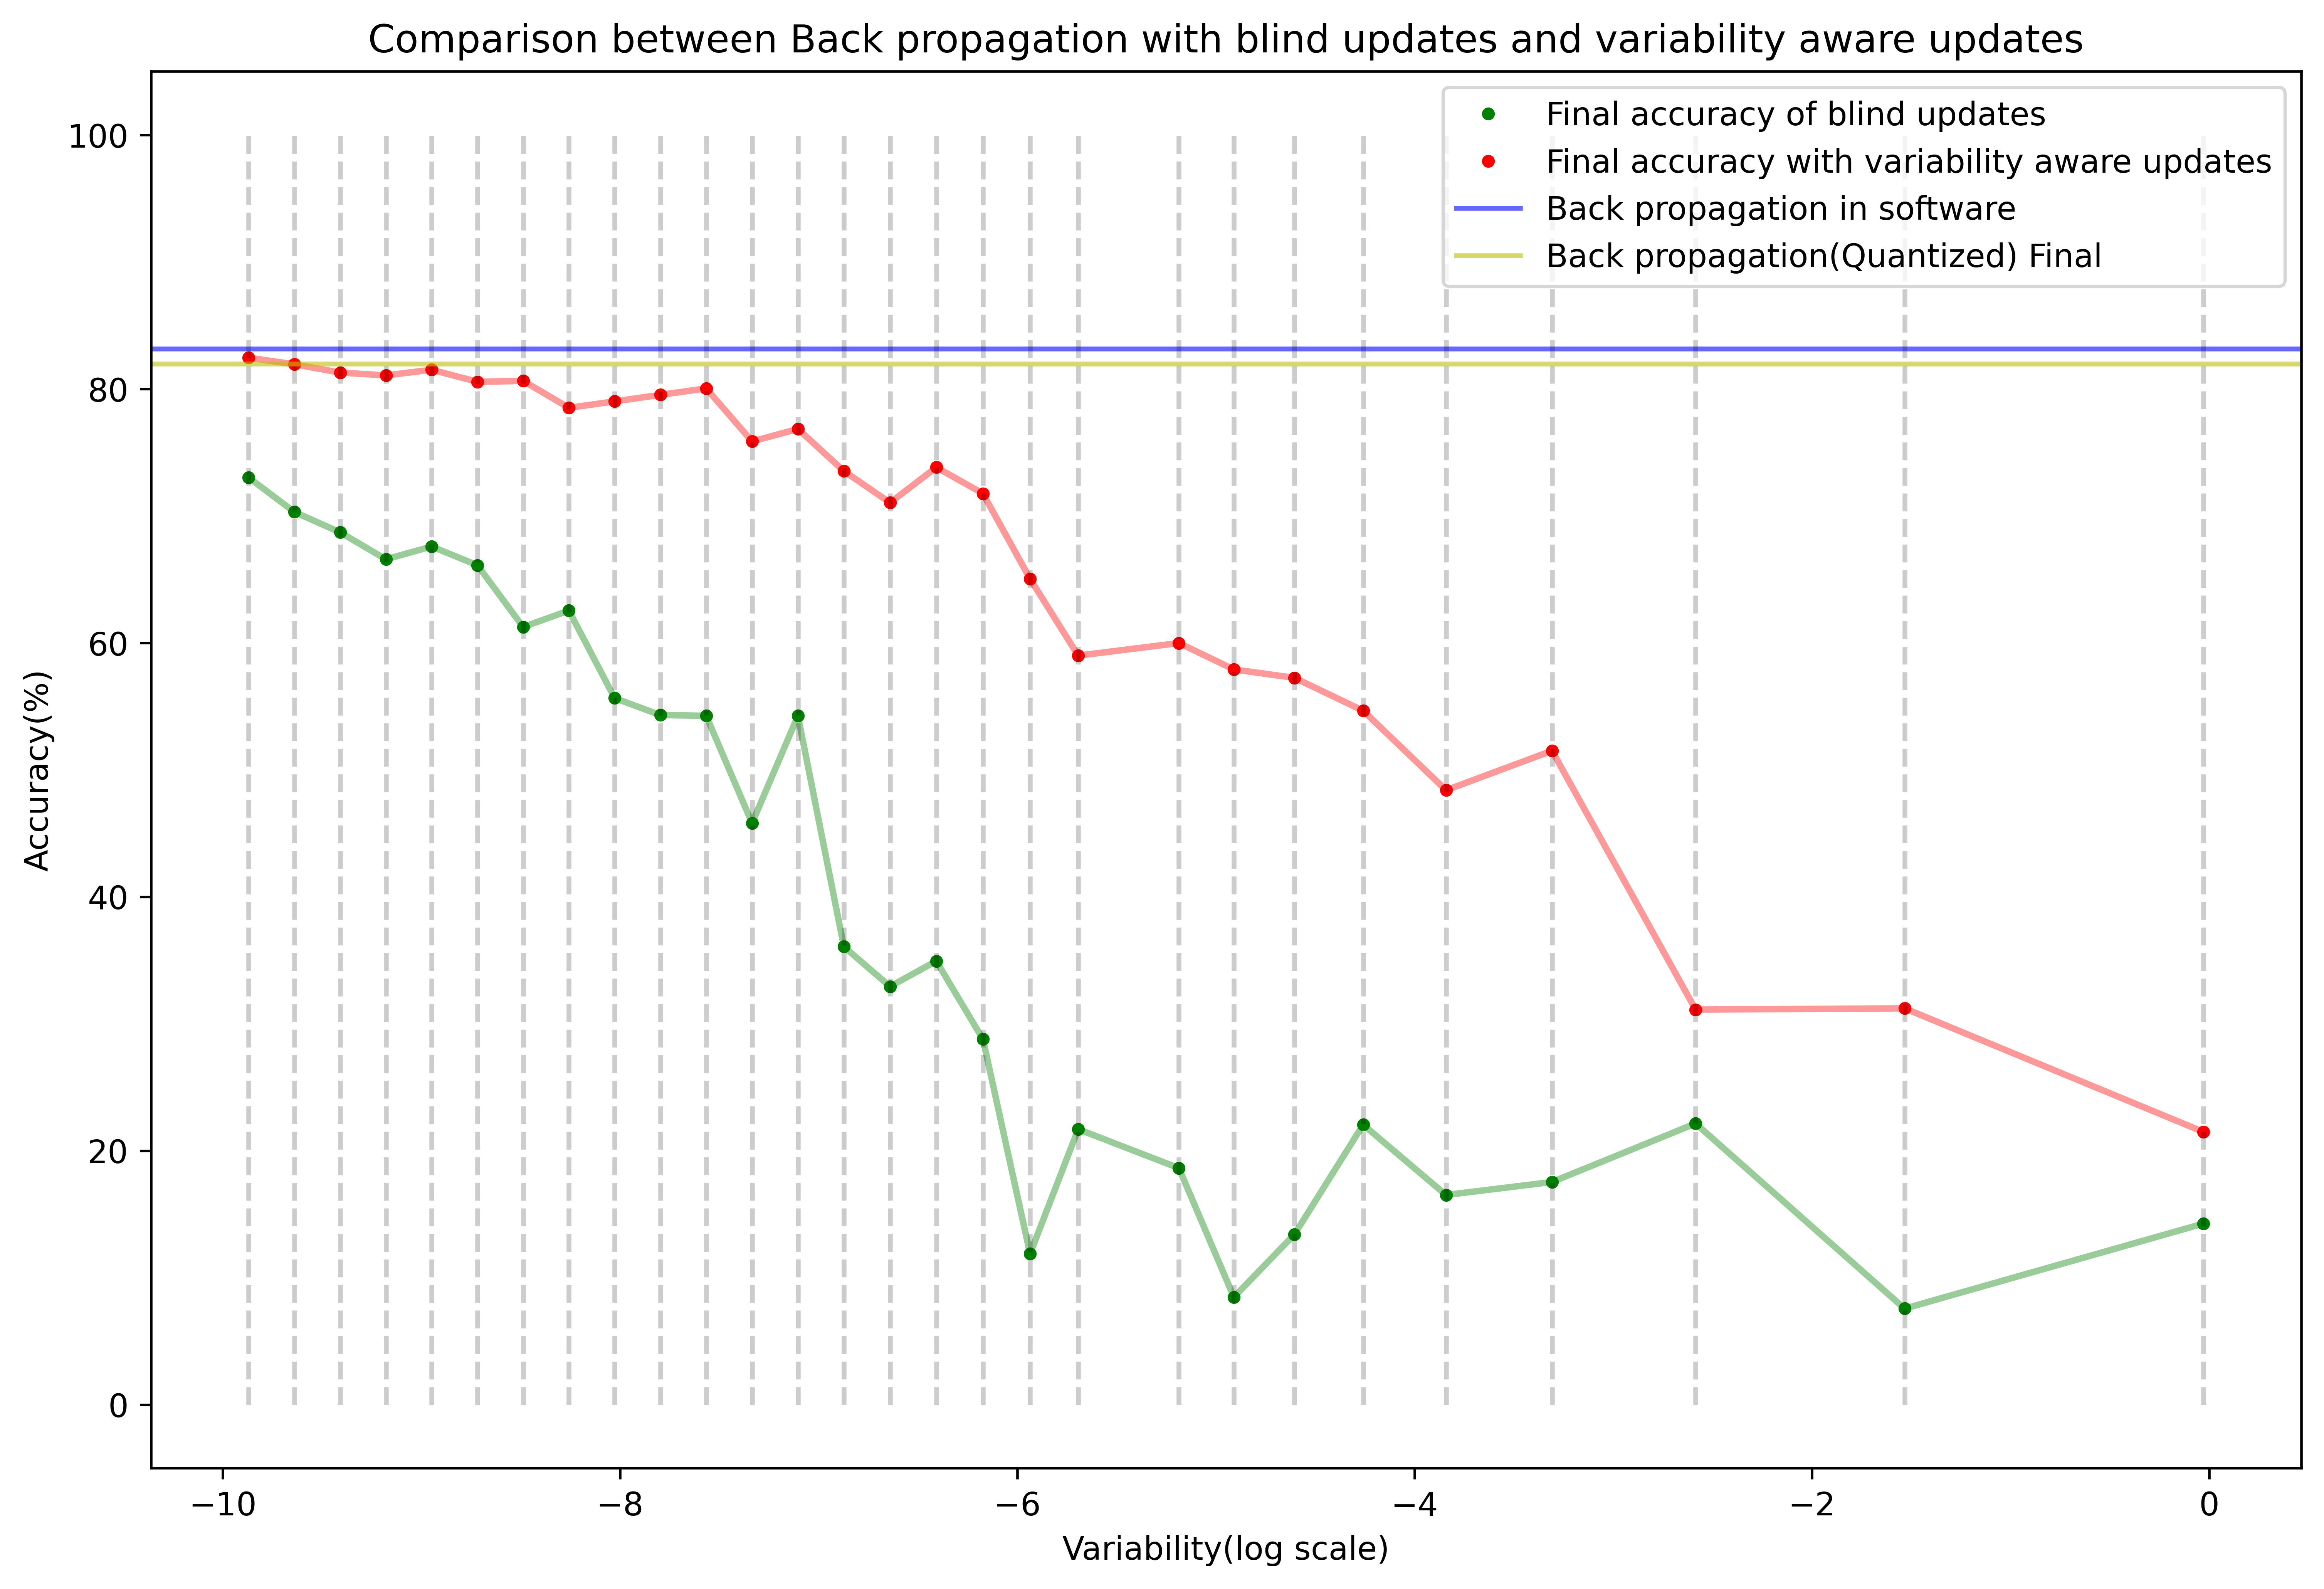

In [37]:
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize = (12, 8))
trainAccBU = [j[0] for j in finTrainAcc]
trainAccVA = [j[1] for j in finTrainAcc]
x = [np.log(i) for i in SigmaIon]
plt.plot(x, trainAccBU, 'g.', label = "Final accuracy of blind updates")
plt.plot(x, trainAccBU, 'g', alpha = 0.4, linewidth = 2)
plt.plot(x, trainAccVA, 'r.', label = "Final accuracy with variability aware updates")
plt.plot(x, trainAccVA, 'r', alpha = 0.4, linewidth = 2)
plt.axhline(83.15714285714286, color = 'b', alpha = 0.6, label = "Back propagation in software")
plt.vlines(x, 0, 100, color = 'k', alpha = 0.2, linestyles='--')
plt.axhline(81.9857, color = 'y', alpha = 0.6, label = "Back propagation(Quantized) Final")
plt.legend()
plt.title("Comparison between Back propagation with blind updates and variability aware updates")
plt.ylabel("Accuracy(%)")
plt.xlabel("Variability(log scale)")

omments:
1. Add 0 variablity for BP - pure quantization effect
2. add weight updates(integer/quantized) - any weight wld do  - at low vaialbity and at moderated variablity 

We will now compare WP and BP with the new update rule

# Statistical runs

In [157]:
mu = 0.7
sigma = 10**(-3.6)
onoff = 10000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10
lr = 0.1

In [158]:
trainAccLowVar = []
valAccLowVar = []
for _ in range(0, 4):
    _, _, _, _, train_acc, val_acc, _, _, _ = batch_grad_descentBPVarUpdateComp(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=10)
    trainAccLowVar.append(train_acc[-1])
    valAccLowVar.append(val_acc[-1])

Params Initialised
Iteration: 10
Training :: Blind : 69.34603174603174 :: VA : 77.16666666666666
Validation  :: Blind : 69.17142857142858 :: VA : 77.41428571428571 :: Blind Loss : 6002.02232518861 :: Val Loss : 4282.077018211983
Iteration: 20
Training :: Blind : 70.07777777777778 :: VA : 78.67460317460318
Validation  :: Blind : 70.6 :: VA : 79.32857142857142 :: Blind Loss : 5806.004574949286 :: Val Loss : 3969.9632843373834
Iteration: 30
Training :: Blind : 70.63174603174603 :: VA : 79.53174603174602
Validation  :: Blind : 70.87142857142858 :: VA : 80.15714285714286 :: Blind Loss : 5727.347822106389 :: Val Loss : 3818.6038558393693
Iteration: 40
Training :: Blind : 70.76984126984127 :: VA : 80.06984126984126
Validation  :: Blind : 70.82857142857144 :: VA : 80.52857142857142 :: Blind Loss : 5707.982375230107 :: Val Loss : 3728.8465520100854
Iteration: 50
Training :: Blind : 70.92063492063491 :: VA : 80.46507936507936
Validation  :: Blind : 70.97142857142858 :: VA : 80.60000000000001 :: 

In [159]:
mu = 0.7
sigma = 10**(-1.8)
onoff = 10000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10
lr = 0.1

In [160]:
trainAccModVar = []
valAccModVar = []
for _ in range(0, 4):
    _, _, _, _, train_acc, val_acc, _, _, _ = batch_grad_descentBPVarUpdateComp(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=10)
    trainAccModVar.append(train_acc[-1])
    valAccModVar.append(val_acc[-1])

Params Initialised
Iteration: 10
Training :: Blind : 13.241269841269842 :: VA : 52.834920634920636
Validation  :: Blind : 13.457142857142856 :: VA : 51.65714285714286 :: Blind Loss : 18589.002475865207 :: Val Loss : 9976.639078268283
Iteration: 20
Training :: Blind : 13.504761904761905 :: VA : 53.15555555555556
Validation  :: Blind : 13.757142857142856 :: VA : 52.15714285714286 :: Blind Loss : 18625.962081297177 :: Val Loss : 9926.737185030375
Iteration: 30
Training :: Blind : 11.823809523809524 :: VA : 53.24761904761905
Validation  :: Blind : 12.028571428571428 :: VA : 52.24285714285715 :: Blind Loss : 19152.850551492455 :: Val Loss : 9909.106189045651
Iteration: 40
Training :: Blind : 14.692063492063493 :: VA : 53.250793650793646
Validation  :: Blind : 15.2 :: VA : 52.28571428571429 :: Blind Loss : 18138.0437444418 :: Val Loss : 9900.183718160984
Iteration: 50
Training :: Blind : 14.787301587301588 :: VA : 53.3079365079365
Validation  :: Blind : 15.257142857142858 :: VA : 52.31428571

In [161]:
mu = 0.7
sigma = 10**(-1.2)
onoff = 10000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10
lr = 0.1

In [162]:
trainAccHighVar = []
valAccHighVar = []
for _ in range(0, 4):
    _, _, _, _, train_acc, val_acc, _, _, _ = batch_grad_descentBPVarUpdateComp(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=10)
    trainAccHighVar.append(train_acc[-1])
    valAccHighVar.append(val_acc[-1])

Params Initialised
Iteration: 10
Training :: Blind : 8.852380952380951 :: VA : 26.05873015873016
Validation  :: Blind : 9.114285714285714 :: VA : 25.642857142857146 :: Blind Loss : 50710.30477090439 :: Val Loss : 17294.02742388571
Iteration: 20
Training :: Blind : 9.280952380952382 :: VA : 27.476190476190474
Validation  :: Blind : 9.728571428571428 :: VA : 27.285714285714285 :: Blind Loss : 43234.624743081156 :: Val Loss : 16872.710040952956
Iteration: 30
Training :: Blind : 11.565079365079365 :: VA : 28.76031746031746
Validation  :: Blind : 10.971428571428572 :: VA : 29.35714285714286 :: Blind Loss : 49459.80307156588 :: Val Loss : 19359.934142580347
Iteration: 40
Training :: Blind : 9.266666666666666 :: VA : 25.10952380952381
Validation  :: Blind : 8.542857142857143 :: VA : 25.442857142857143 :: Blind Loss : 51076.246623270876 :: Val Loss : 19128.827445441468
Iteration: 50
Training :: Blind : 10.692063492063491 :: VA : 29.039682539682538
Validation  :: Blind : 10.928571428571429 :: V

In [170]:
trainAccLowVar

[[70.96666666666667, 81.36825396825397],
 [67.92063492063492, 80.88888888888889],
 [67.60634920634921, 81.11904761904762],
 [66.2047619047619, 82.04603174603174]]

In [171]:
trainAccModVar

[[11.836507936507937, 53.3047619047619],
 [25.585714285714285, 50.6888888888889],
 [22.1968253968254, 61.27619047619047],
 [14.27142857142857, 54.83809523809524]]

In [172]:
trainAccHighVar

[[8.998412698412698, 30.341269841269842],
 [19.33174603174603, 23.020634920634922],
 [9.6, 33.114285714285714],
 [12.47936507936508, 42.696825396825396]]

In [199]:
import pandas as pd
tlbu = [j[0] for j in trainAccLowVar]
tlva = [j[1] for j in trainAccLowVar]
tmbu = [j[0] for j in trainAccModVar]
tmva = [j[1] for j in trainAccModVar]
thbu = [j[0] for j in trainAccHighVar]
thva = [j[1] for j in trainAccHighVar]
s1 = ["blind" for _ in trainAccLowVar]
s2 = ["Aware" for _ in trainAccLowVar]
c1 = ["Low Var" for _ in trainAccLowVar]
c2 = ["Mod Var" for _ in trainAccModVar]
c3 = ["High Var" for _ in trainAccHighVar]
total_bill = tlbu + tlva + tmbu + tmva + thbu + thva
sex = s1 + s2 + s1 +s2 +s1 +s2
day = c1 + c1 + c2 +c2 +c3 +c3
df = pd.DataFrame({'Accuracy':total_bill, "Update rule":sex, "Variability":day})
df

,Accuracy,Update rule,Variability
0,70.966667,blind,Low Var
1,67.920635,blind,Low Var
2,67.606349,blind,Low Var
3,66.204762,blind,Low Var
4,81.368254,Aware,Low Var
5,80.888889,Aware,Low Var
6,81.119048,Aware,Low Var
7,82.046032,Aware,Low Var
8,11.836508,blind,Mod Var
9,25.585714,blind,Mod Var


In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects


def add_median_labels(ax, fmt='.1f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                        color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=1, foreground=median.get_color()),
            path_effects.Normal(),
        ])


#tips = sns.load_dataset("tips")
plt.figure(figsize = (12,20))
ax = sns.boxplot(data=df, x='Variability', y='Accuracy', hue="Update rule")
add_median_labels(ax)
plt.title("Statistical runs for different cases of variability", fontsize = 15)
plt.show()
#low = 10**(-3.6)
##moderate = 10**(-1.8)
#high = 10**(-1.2)

# Comparing integer weight updates for blind updates and variability aware updates

In [201]:
def batch_grad_descentBPVarUpdateCompIntW(X,Y,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = 47)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1bu = W1.copy()
  b1bu = b1.copy()
  W2bu = W2.copy()
  b2bu = b2.copy()

  #variability aware updates
  W1va = W1.copy()
  b1va = b1.copy()
  W2va = W2.copy()
  b2va = b2.copy()

  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)



  W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)
  b1lookUp = createLookUpTable2d(b1, b1Currents, precision, step, discreteSteps, wRange)
  W2lookUp = createLookUpTable2d(W2, W2Currents, precision, step, discreteSteps, wRange)
  b2lookUp = createLookUpTable2d(b2, b2Currents, precision, step, discreteSteps, wRange)

  wVACycle = []
  wBUCycle = []


  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
      wIniva = W1va[7, 100] #storing the initial weight value qauantized
      # wIniVA = W1va.copy()
      W1varoc = weightTransformWithVariability(W1va, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1va, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2va, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2va, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)


      #W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)
      #actualW1vaUpdate = W1varoc - weightTransformWithVariability(findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1), W1Currents, precision, step, discreteSteps, wRange)
      W1va = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      b1va = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      W2va = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      b2va = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))
      wVACycle.append(W1va[7, 100] - wIniva)
      # print(W1va[7, 100] - wIniva)
      # plt.figure()
      # plt.plot((W1va - wIniVA).flatten()/step)
      


      #blind updates
      wInibu = W1bu[7, 100] #storing the initial weight value qauantized
      wIniBU = W1bu.copy()
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1bu, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)

      W1bu, b1bu, W2bu, b2bu = param_update(W1varoc, b1varoc, W2varoc,b2varoc, dW1bu, db1, dW2, db2, lr = lr)

      W1bu = roundArbitrary(W1bu, step, wRange)#weights have to maintained as their digitized versions
      b1bu = roundArbitrary(b1bu, step, wRange)
      W2bu = roundArbitrary(W2bu, step, wRange)
      b2bu = roundArbitrary(b2bu, step, wRange)
      wBUCycle.append(W1bu[7, 100] - wInibu)
      # plt.plot((W1bu - wIniBU).flatten()/step)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(sampled_x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


      W1varoc = weightTransformWithVariability(W1va, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1va, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2va, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2va, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(sampled_x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      vaAccTrainAcc = accuracy(predictions(A2_train), Y)
      vaTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      vaAccValAcc = accuracy(predictions(A2_val), y_val)
      vaValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))
  
      train_acc.append([buAccTrainAcc, vaAccTrainAcc])
      print(f'Training :: Blind : {buAccTrainAcc} :: VA : {vaAccTrainAcc}')


      val_acc.append([buAccValAcc, vaAccTrainAcc])
      print(f'Validation  :: Blind : {buAccValAcc} :: VA : {vaAccValAcc} :: Blind Loss : {buValLoss} :: Val Loss : {vaValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return wVACycle, wBUCycle


In [203]:
mu = 0.7
sigma = 0.001
onoff = 10000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10
lr = 0.1

In [204]:
#finding qauantization accuacy
x, uwu = batch_grad_descentBPVarUpdateCompIntW(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1)

Params Initialised
Iteration: 1
Training :: Blind : 45.32698412698413 :: VA : 57.72698412698413
Validation  :: Blind : 43.92857142857143 :: VA : 56.871428571428574 :: Blind Loss : 11292.348019576679 :: Val Loss : 8433.785441163964
Iteration: 2
Training :: Blind : 51.65714285714286 :: VA : 66.27777777777779
Validation  :: Blind : 50.114285714285714 :: VA : 65.81428571428572 :: Blind Loss : 10061.775455602787 :: Val Loss : 6765.717819348667
Iteration: 3
Training :: Blind : 53.390476190476186 :: VA : 69.18253968253968
Validation  :: Blind : 51.82857142857142 :: VA : 68.68571428571428 :: Blind Loss : 9387.421707939604 :: Val Loss : 6088.491098692434
Iteration: 4
Training :: Blind : 53.33015873015873 :: VA : 70.9095238095238
Validation  :: Blind : 52.114285714285714 :: VA : 70.68571428571428 :: Blind Loss : 9226.885013296534 :: Val Loss : 5711.303641468517
Iteration: 5
Training :: Blind : 53.34444444444445 :: VA : 72.01269841269841
Validation  :: Blind : 52.042857142857144 :: VA : 72.128571

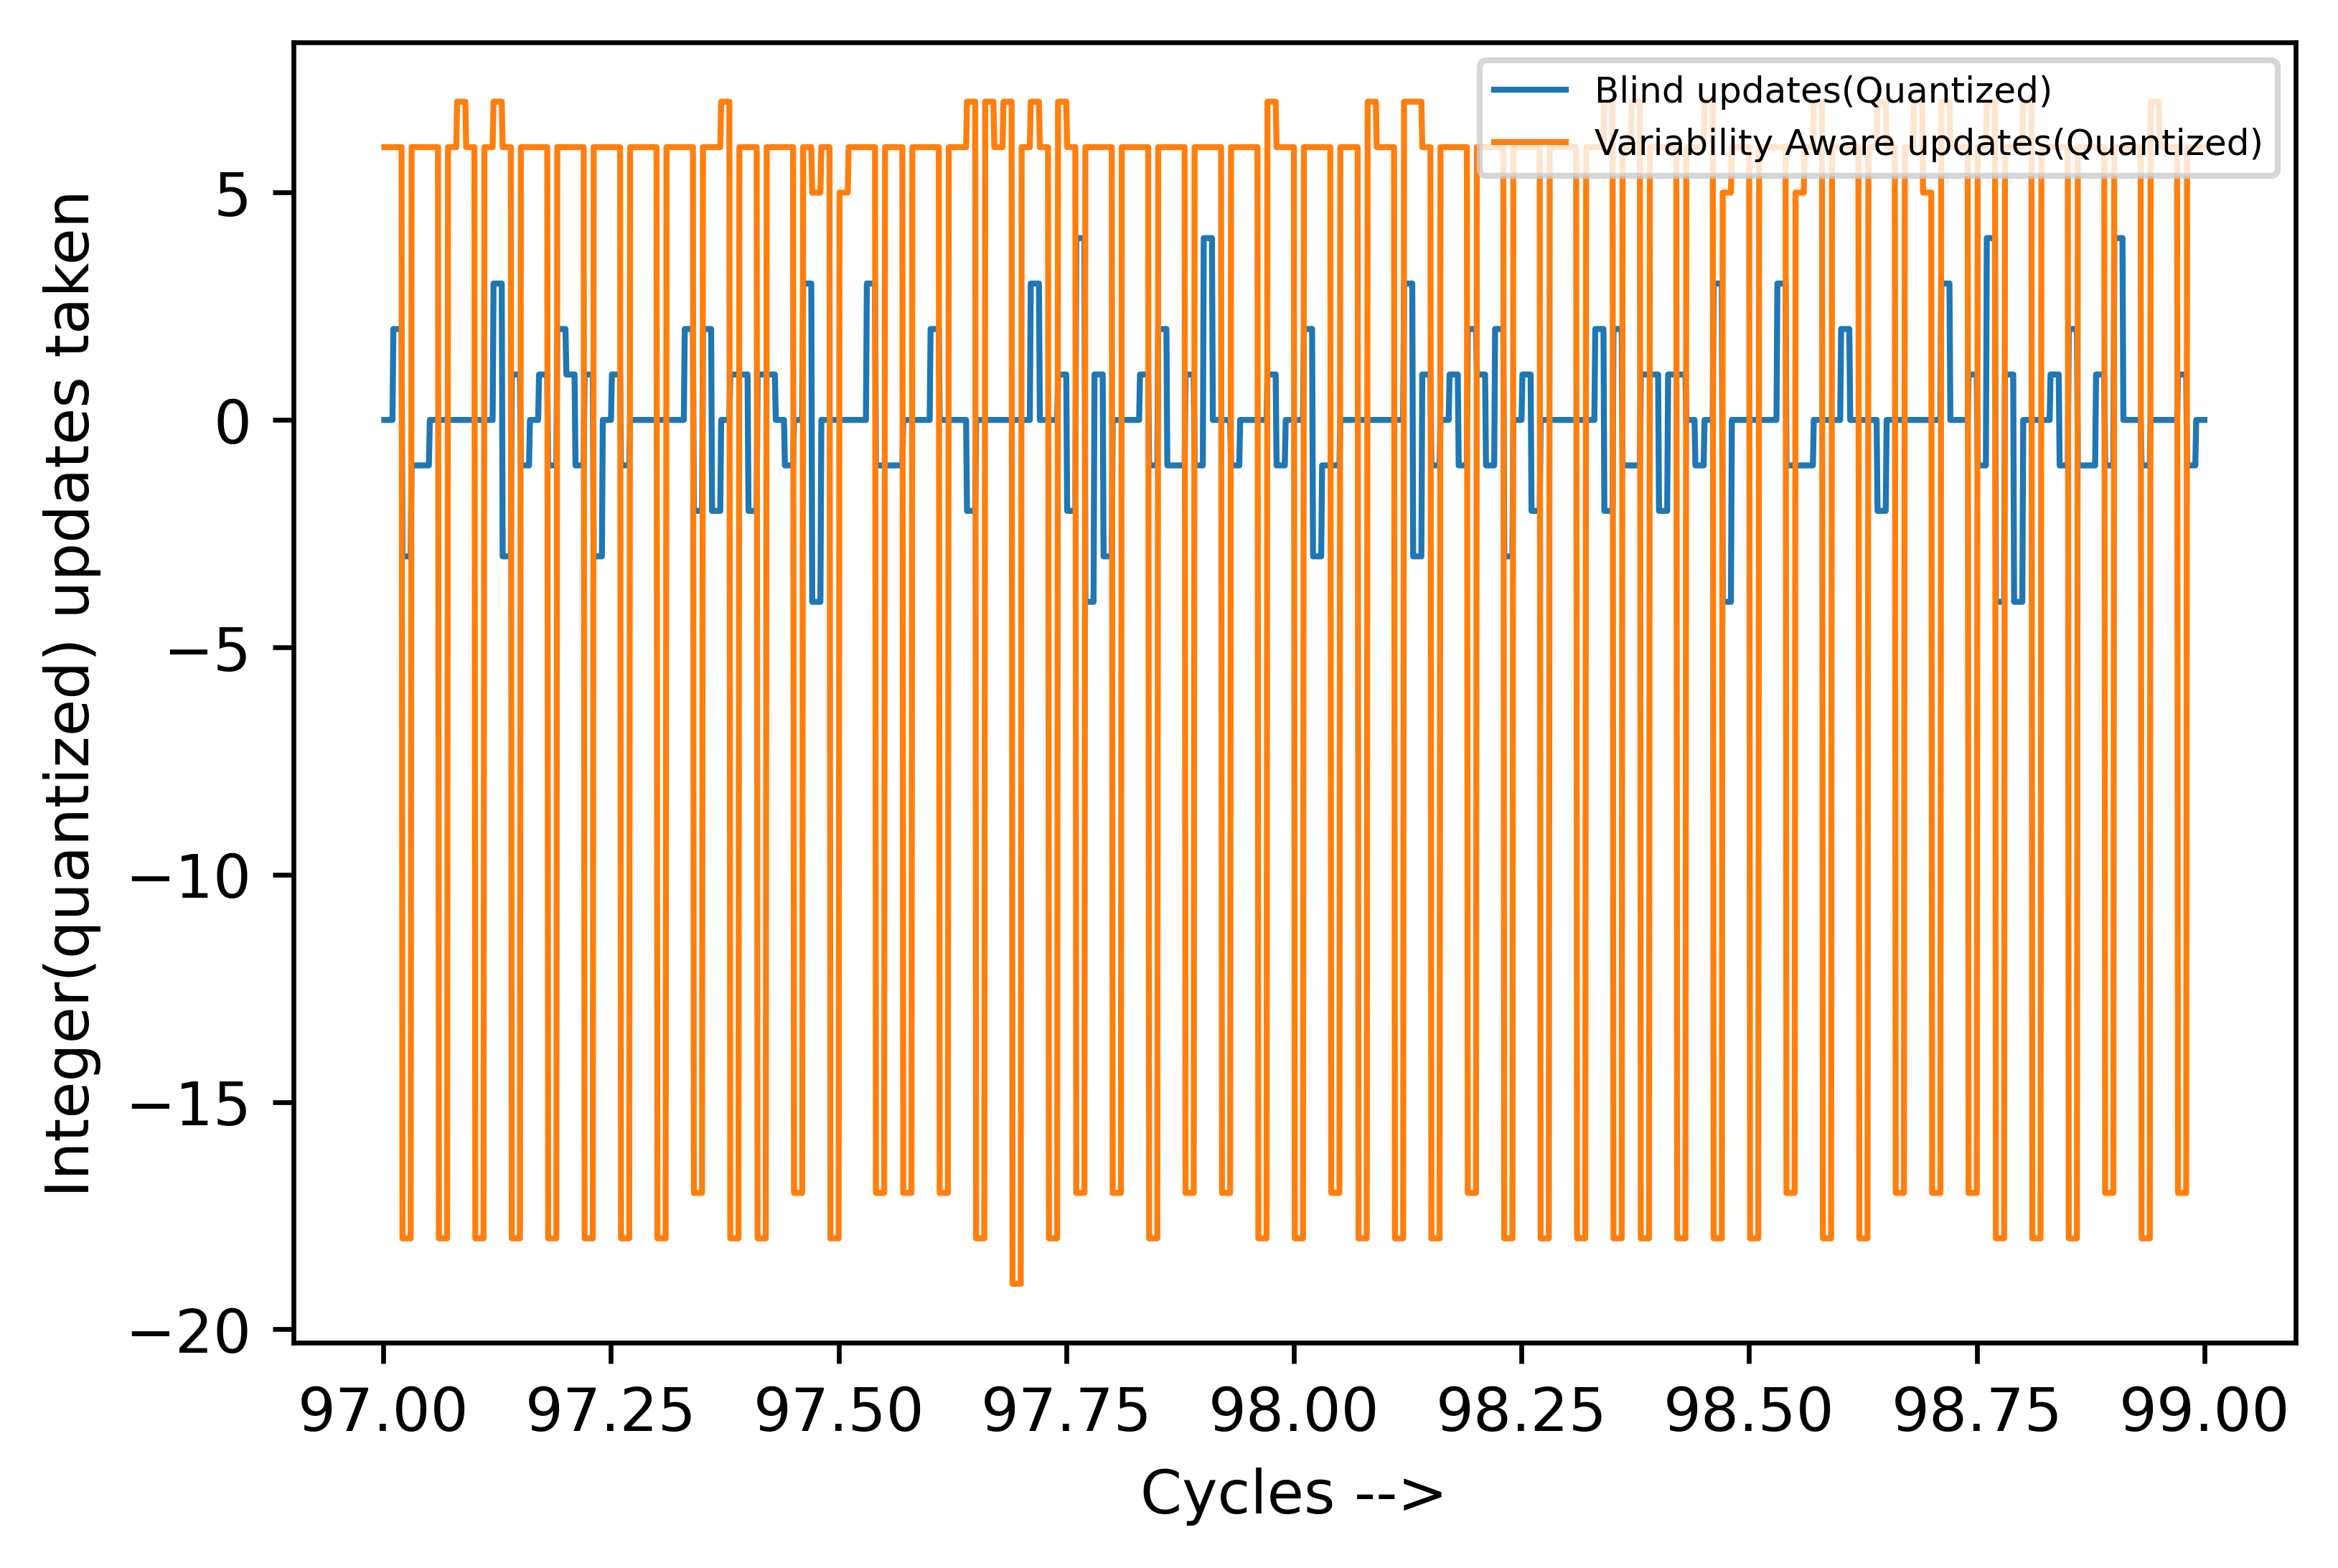

In [225]:
xArr = np.array(x)
xAxis = np.linspace(0, len(xArr), 100000)
#yAxis = [i for j in range(0, int(len(xArr)/10000)) for i in xArr]
yAxis = []
for i in xArr:
    for j in range(0, int(100000/len(xArr))):
        yAxis.append(i/step)


uwuArr = np.array(uwu)
uwuAxis = np.linspace(0, len(uwuArr), 100000)
#yAxis = [i for j in range(0, int(len(xArr)/10000)) for i in xArr]
uwuyAxis = []
for i in uwuArr:
    for j in range(0, int(100000/len(uwuArr))):
        uwuyAxis.append(i/step)
start = 97 *  (100*int(100000/len(xArr)))
end = 99 *  (100*int(100000/len(xArr)))
plt.figure()
plt.plot(xAxis[start:end]/100, yAxis[start:end], linewidth = 1, label = "Blind updates(Quantized)")
plt.plot(uwuAxis[start:end]/100, uwuyAxis[start:end], linewidth = 1, label = "Variability Aware updates(Quantized)")
plt.xlabel("Cycles -->")
plt.ylabel("Integer(quantized) updates taken")
plt.legend(loc=1, prop={'size': 6})

## Implementing WP

In [482]:
def WPwithVarUp(W1, b1, W2, b2, pert, lossBeforePert, X, y, precision, step, discreteSteps, wRange,  W1Var, b1Var, W2Var, b2Var, W1Currents, b1Currents, W2Currents, b2Currents):
    #assert pert==step #to get increments of '1' in the bit pattern of the weight array
    #!here we chnage perturb only one value
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    
    W1pert = W1.copy()
    W1pert += pert
    W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pertLoop = W1Var.copy()
            W1pertLoop[i, j] = W1pertArrTr[i, j]
            #print(W1pertLoop - W1Var)
            #plt.figure()
            #plt.plot(W1Var.flatten(), W1pertLoop.flatten(), '.')
            #plt.title("W1 comp")
            #do the transform only on that perturbed weight and place it in the correct place
            #W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1pertLoop, b1Var, W2Var, b2Var)
            #print(A2pert)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
            dW1[i, j] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(W1pertArrTr[i,j] - W1Var[i,j]+ 10e-16)
    #dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert
    #print(lossAfterPertW1-lossBeforePert)


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)

    b1pert = b1.copy()
    b1pert +=pert
    b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)

    for i in range(b1.shape[0]):
        b1pertLoop = b1Var.copy()
        b1pertLoop[i]=b1pertArrTr[i]
        #b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1pertLoop, W2Var, b2Var)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
        db1[i] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(b1pertArrTr[i] - b1Var[i] + 10e-16)
    #db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)

    W2pert = W2.copy()
    W2pert += pert
    W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)

    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pertLoop = W2Var.copy()
            W2pertLoop[i, j] = W2pertArrTr[i, j]
            #W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1Var, b1Var, W2pertLoop, b2Var)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
            dW2[i, j] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(W2pertArrTr[i,j] - W2Var[i,j]+ 10e-16)
    #dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert
    #print(lossAfterPertW2)


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)

    b2pert = b2.copy()
    b2pert += pert
    b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)


    for i in range(b2.shape[0]):
        b2pertLoop = b2Var.copy()
        b2pertLoop[i] = b2pertArrTr[i]
        #b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1Var, W2Var, b2pertLoop)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
        db2[i] = 1/m * (np.sum(crossEntropy(one_hot_encoding(y), A2pert))-lossBeforePert)/(b2pertArrTr[i] - b2Var[i]+ 10e-16)

    #db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [487]:
def batch_grad_descentBPWPVarUpdateComp(X,Y,iter, pert, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = None)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1bp = W1.copy()
  b1bp = b1.copy()
  W2bp = W2.copy()
  b2bp = b2.copy()

  #variability aware updates
  W1wp = W1.copy()
  b1wp = b1.copy()
  W2wp = W2.copy()
  b2wp = b2.copy()

  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)



  W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)
  b1lookUp = createLookUpTable2d(b1, b1Currents, precision, step, discreteSteps, wRange)
  W2lookUp = createLookUpTable2d(W2, W2Currents, precision, step, discreteSteps, wRange)
  b2lookUp = createLookUpTable2d(b2, b2Currents, precision, step, discreteSteps, wRange)


  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
      W1varoc = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)


      #W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)
      #actualW1vaUpdate = W1varoc - weightTransformWithVariability(findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1), W1Currents, precision, step, discreteSteps, wRange)
      W1bp = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      b1bp = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      W2bp = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      b2bp = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))
      


      #blind updates
      W1varoc = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      #dW1, db1, dW2, db2 = WP(W1, b1, W2, b2, pert=pert, lossBeforePert=loss, X=X1, y=Y1)
      dW1, db1, dW2, db2 = WPwithVarUp(W1wp, b1wp, W2wp, b2wp, pert, loss, X1, Y1, precision, step, discreteSteps, wRange,  W1varoc, b1varoc, W2varoc, b2varoc, W1Currents, b1Currents, W2Currents, b2Currents)


      W1wp = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      b1wp = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      W2wp = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      b2wp = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      W1varoc = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(sampled_x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


      W1varoc = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(sampled_x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      vaAccTrainAcc = accuracy(predictions(A2_train), Y)
      vaTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      vaAccValAcc = accuracy(predictions(A2_val), y_val)
      vaValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))
  
      train_acc.append([buAccTrainAcc, vaAccTrainAcc])
      print(f'Training :: BP : {buAccTrainAcc} :: WP : {vaAccTrainAcc}')


      val_acc.append([buAccValAcc, vaAccTrainAcc])
      print(f'Validation  :: BP : {buAccValAcc} :: WP : {vaAccValAcc} :: Blind Loss : {buValLoss} :: Val Loss : {vaValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [492]:
mu = 0.7
sigma = 0.01
onoff = 10000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10
lr = 0.1

In [493]:
batch_grad_descentBPWPVarUpdateComp(sampled_x_train,y_train,iter, step, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1)

Params Initialised
Iteration: 1
Training :: BP : 39.63650793650794 :: WP : 39.1920634920635
Validation  :: BP : 39.04285714285714 :: WP : 38.68571428571428 :: Blind Loss : 12698.113601344006 :: Val Loss : 12841.546560092138
Iteration: 2
Training :: BP : 42.20952380952381 :: WP : 42.114285714285714
Validation  :: BP : 42.0 :: WP : 41.55714285714286 :: Blind Loss : 12026.456834755718 :: Val Loss : 12246.729014901415
Iteration: 3
Training :: BP : 45.29365079365079 :: WP : 44.53333333333334
Validation  :: BP : 45.1 :: WP : 44.01428571428572 :: Blind Loss : 11496.71558284461 :: Val Loss : 11658.908266759472
Iteration: 4
Training :: BP : 47.41587301587302 :: WP : 46.74126984126984
Validation  :: BP : 46.714285714285715 :: WP : 46.15714285714286 :: Blind Loss : 11086.743768365868 :: Val Loss : 11191.51750109172
Iteration: 5
Training :: BP : 48.92063492063492 :: WP : 47.84920634920635
Validation  :: BP : 48.47142857142857 :: WP : 47.05714285714286 :: Blind Loss : 10870.456273276526 :: Val Loss

KeyboardInterrupt: 

## Explaining variability and the problem it causes with updates

Fixing the notation:

We decorate values (floating or integers) with subscripts. Any number with the subscript 'v' denotes value emmitted from the SRAM cell due to variability while 'q' represents the qauntized state of the SRAM cell. We denote,
$$V : \mathbb{Q} \rightarrow \mathbb{R} \; \text{ as the variability transform where $\mathbb{Q}$ is the possible states of the cell}$$

Let us say our SRAM cell has the following variability:

| V         | V($1_q$)    | V($2_q$) | V($3_q$) |V($4_q$) |V($5_q$) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| State       | 1       | 2       | 3       | 4       | 5       |
| Emmission   | Text        |

1. adpative learning rule for the learning rate as a function of epochs egs lr = lr*(1 + k*epoch)

2. Compare with quantization than software since quantization is assumed in variability

3. Try to improve accuracy to respectable numbers

Step 1: Try running the BP vs BP variability aware vs blind updates comparison first 